In [1]:
from datasets import load_dataset
import os
import numpy as np
import pandas as pd
from hazm import stopwords_list
import re
from hazm import word_tokenize
from hazm import Normalizer , Stemmer , WordTokenizer , Lemmatizer , stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Embedding , LSTM , Dropout
from tensorflow.keras.models import Sequential , load_model
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix , accuracy_score , recall_score , precision_score , roc_curve , auc , f1_score , roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

c:\python311\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


In [2]:
# Load SnappFood dataset from Hugging Face
dataset = load_dataset("ParsiAI/snappfood-sentiment-analysis")

# Convert splits to pandas DataFrames
train_df = dataset["train"].to_pandas()
valid_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

# Save each as CSV
folder_name = "data/raw"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print("Folder created.")

    train_df.to_csv(f"{folder_name}/snappfood_train.csv", index=False, encoding="utf-8")
    valid_df.to_csv(f"{folder_name}/snappfood_validation.csv", index=False, encoding="utf-8")
    test_df.to_csv(f"{folder_name}/snappfood_test.csv", index=False, encoding="utf-8")

else:
    print("Folder already exists.")

print("CSV files successfully saved!")

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /datasets/ParsiAI/snappfood-sentiment-analysis/resolve/main/README.md (Caused by ProxyError('Unable to connect to proxy', ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001B4403C0ED0>, 'Connection to 192.168.1.2 timed out. (connect timeout=10)')))"), '(Request ID: c6bc7799-671d-4198-be12-cd0f84d895c4)')' thrown while requesting HEAD https://huggingface.co/datasets/ParsiAI/snappfood-sentiment-analysis/resolve/main/README.md
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /datasets/ParsiAI/snappfood-sentiment-analysis/resolve/main/README.md (Caused by ProxyError('Unable to connect to proxy', ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001B4403E1250>, 'Connection to 192.168.1.2 timed out. (connect timeout=10)')))"), '(Request ID: 924c1be1-e1c7-4cd8-b01e-9b96

Folder already exists.
CSV files successfully saved!


In [3]:
train_df.head()

,comment,label,label_id
0,غذا خیلی سرد بود در صورتیکه فاصله ما خیلی کم است,SAD,1.0
1,بهتره بتونیم ران یا سینه رو خودمون انتخاب کنیم,HAPPY,0.0
2,غذا بد بود حالم خیییییلی بده. دل دردو دل پیچه....,SAD,1.0
3,با سلام سابق بر این بسته بندی از کیفیت بهتری ب...,SAD,1.0
4,سلام، خیلی ممنون و متشکرم,HAPPY,0.0


In [4]:
valid_df.head(2)

,comment,label,label_id
0,درسته که توی فودپارتی راضی شدید تخفیف بیشتری ب...,SAD,1.0
1,سلام تخم مرغ را برندی دیگه فرستادن قرار شدن عو...,SAD,1.0


In [5]:
test_df.tail(2)

,comment,label,label_id
9031,غذای خوبی بود نسبت به قیمتش,HAPPY,0.0
9032,تمام شیرینی‌ها خرد شده بود,SAD,1.0


In [6]:
stopwords = {
"و","در","به","از","که","با","است","را","برای","این","آن","تا","یا","اما","اگر","هر","یک","هم","همان","خود",
"شود","شده","شوند","کرد","کردن","می","های","هایش","آنها","ما","شما","او","من","تو","چرا","چگونه","چه",
"کجا","کی","یا","همچنین","بسیار","زیاد","کم","دیگر","نیز","بی","هیچ","پس","قبل","بعد","چون","نه","آیا",
"بود","باشد","باشند","نیست","نیستند","هست","هستند","باشد","داشت","دارم","دارید","دارند",
"مگر","حتی","بین","توسط","روی","تحت","بدون","مثل","مانند","اما","بلکه","زیرا","چنانچه"
}

normalize = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
tokenizer = WordTokenizer()


def preprocess(text , stem_ok = True , lemat_ok = True):
    text = normalize.normalize(text)

    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    text = re.sub(r"[^\w\s\u263a-\U0001f999]", " ", text)
    text = re.sub(r"\d+", "", text)

    token = tokenizer.tokenize(text)

    token = [word for word in token if word not in stopwords]
    if stem_ok:
        token = [stemmer.stem(word) for word in token]
    elif lemat_ok:
        token = [lemmatizer.lemmatize(word) for word in token]
    return ' '.join(token)

In [7]:
sample = "غذااااا خیلی دیر رسید ولی خوشمزه بود 😍🔥"
print(preprocess(sample , stem_ok=True , lemat_ok=False))

غذا خیل دیر رسید ول خوشمزه 😍🔥


In [8]:
sample = "غذااااا خیلی دیر رسید ولی خوشمزه بود 😍🔥"
print(preprocess(sample , lemat_ok=True , stem_ok=False))

غذا خیلی دیر رسید ولی خوشمزه 😍🔥


In [9]:
def apply_preprocess(row):
    row["clean_text"] = preprocess(row["comment"] , lemat_ok=True   , stem_ok=False)
    return row


train_df["clean_text"] = train_df["comment"].apply(preprocess)
valid_df["clean_text"] = valid_df["comment"].apply(preprocess)
test_df["clean_text"] = test_df["comment"].apply(preprocess)

In [10]:
train_df.iloc[122]

comment       کیفیت برنج خوب بود ولی کیفیت جوجه واقعا بد بود...
label                                                       SAD
label_id                                                    1.0
clean_text    کیف برنج خوب ول کیف جوجه واقعا بد انقد سف اصلا...
Name: 122, dtype: object

In [11]:
def create_vectorizer(train_df, valid_df, text_col="clean_text", max_features=30000, ngram=(1,2)):
    """
    train_df, valid_df: DataFrames containing text and labels
    text_col: clean text column name
    max_features: TF-IDF max vocabulary size
    ngram: tuple to define n-gram range (default bigram)
    """

    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram)

    # Fit on training and transform both
    X_train = vectorizer.fit_transform(train_df[text_col])
    X_valid = vectorizer.transform(valid_df[text_col])

    return vectorizer, X_train, X_valid

In [12]:
def train_model(model , X_train , y_train):
    model.fit(X_train , y_train)
    return model

In [13]:
def evaluate_with_threshold(model, X_train, y_train, X_val, y_val, X_test, y_test,
                            threshold=0.5, save_csv=True, filename="results/evaluation_results.csv"):

    results = {}

    # TRAIN
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_pred_train = (y_prob_train > threshold).astype(int)

    results["train_accuracy"] = accuracy_score(y_train, y_pred_train)
    results["train_precision"] = precision_score(y_train, y_pred_train)
    results["train_recall"] = recall_score(y_train, y_pred_train)
    results["train_f1"] = f1_score(y_train, y_pred_train)
    results["train_auc"] = roc_auc_score(y_train, y_prob_train)

    # VALIDATION
    y_prob_val = model.predict_proba(X_val)[:, 1]
    y_pred_val = (y_prob_val > threshold).astype(int)

    results["val_accuracy"] = accuracy_score(y_val, y_pred_val)
    results["val_precision"] = precision_score(y_val, y_pred_val)
    results["val_recall"] = recall_score(y_val, y_pred_val)
    results["val_f1"] = f1_score(y_val, y_pred_val)
    results["val_auc"] = roc_auc_score(y_val, y_prob_val)

    # TEST
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_prob_test > threshold).astype(int)

    results["test_accuracy"] = accuracy_score(y_test, y_pred_test)
    results["test_precision"] = precision_score(y_test, y_pred_test)
    results["test_recall"] = recall_score(y_test, y_pred_test)
    results["test_f1"] = f1_score(y_test, y_pred_test)
    results["test_auc"] = roc_auc_score(y_test, y_prob_test)

    # Convert to DataFrame
    df_results = pd.DataFrame([results])

    # Save results if needed
    if save_csv:
        df_results.to_csv(filename, index=False, encoding="utf-8")
        print(f"Results saved to {filename}")

    return model , df_results, y_pred_train, y_pred_val, y_pred_test


In [14]:
def evaluate_classification(model, X, y, threshold=0.5, title="Classification Report"):

    # probability of positive class
    y_prob = model.predict_proba(X)[:, 1]

    # convert probabilities to label with threshold
    y_pred = (y_prob > threshold).astype(int)

    print(f" {title}")
    print("-" * 50)
    print(classification_report(y, y_pred, target_names=["منفی", "مثبت"]))

    # Plot Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred: منفی", "Pred: مثبت"],
                yticklabels=["Actual: منفی", "Actual: مثبت"])
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return y_pred, y_prob


In [15]:
def plot_eval_charts(model, X_train, y_train, X_val, y_val, X_test, y_test, threshold=0.5):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Evaluation Plots: ROC-AUC and Confusion Matrices", fontsize=16, weight="bold")

    datasets = {
        "Train": (X_train, y_train),
        "Validation": (X_val, y_val),
        "Test": (X_test, y_test),
    }

    # 1) ROC CURVES
    for ax, (name, (X, y)) in zip(axes[0], datasets.items()):
        y_prob = model.predict_proba(X)[:, 1]

        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax.set_title(f"{name} ROC Curve")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()

    # 2) CONFUSION MATRICES
    for ax, (name, (X, y)) in zip(axes[1], datasets.items()):
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = (y_prob > threshold).astype(int)

        cm = confusion_matrix(y, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"{name} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


In [16]:
vectorizer , X_train , X_valid = create_vectorizer(train_df=train_df , valid_df=valid_df)
y_train = train_df['label_id']
y_valid = valid_df['label_id']
vectorizer

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [17]:
X_test = test_df['clean_text']
y_test = test_df['label_id']
X_test = vectorizer.transform(test_df['clean_text'])

Results saved to results/evaluation_results.csv

 Logistic Regression Results:


,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
0,0.891748,0.859366,0.934993,0.895585,0.956898,0.859542,0.823184,0.913589,0.866034,0.928679,0.859847,0.832421,0.903453,0.866484,0.924534


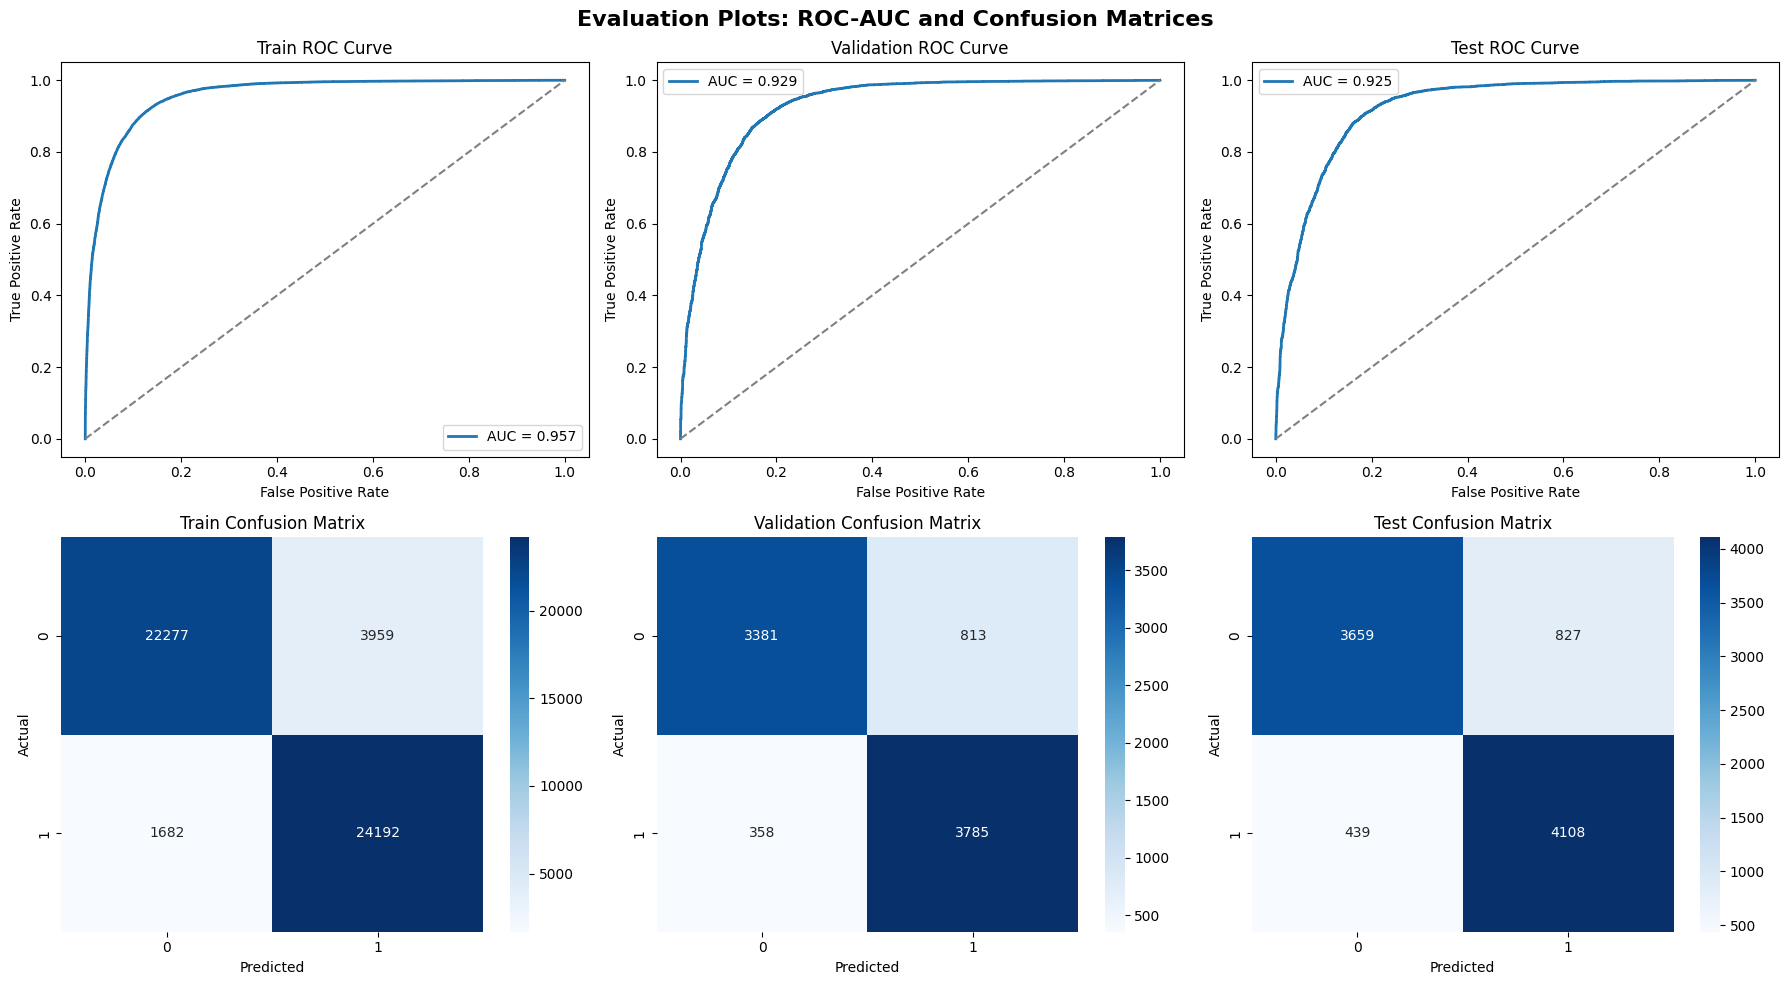

In [18]:
# Evaluation function
model_logistic , results_df, y_pred_train, y_pred_val, y_pred_test = evaluate_with_threshold(
    model=train_model(LogisticRegression(max_iter=3000), X_train, y_train),
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    save_csv=True
)

print("\n Logistic Regression Results:")
display(results_df)

# Plots
plot_eval_charts(
    model=model_logistic,
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5
)

Results saved to results/nb_results.csv

 Naive Bayes Results:


,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
0,0.876262,0.836696,0.932867,0.882168,0.949287,0.852345,0.810051,0.918175,0.860731,0.923513,0.84778,0.808801,0.913569,0.857999,0.918618


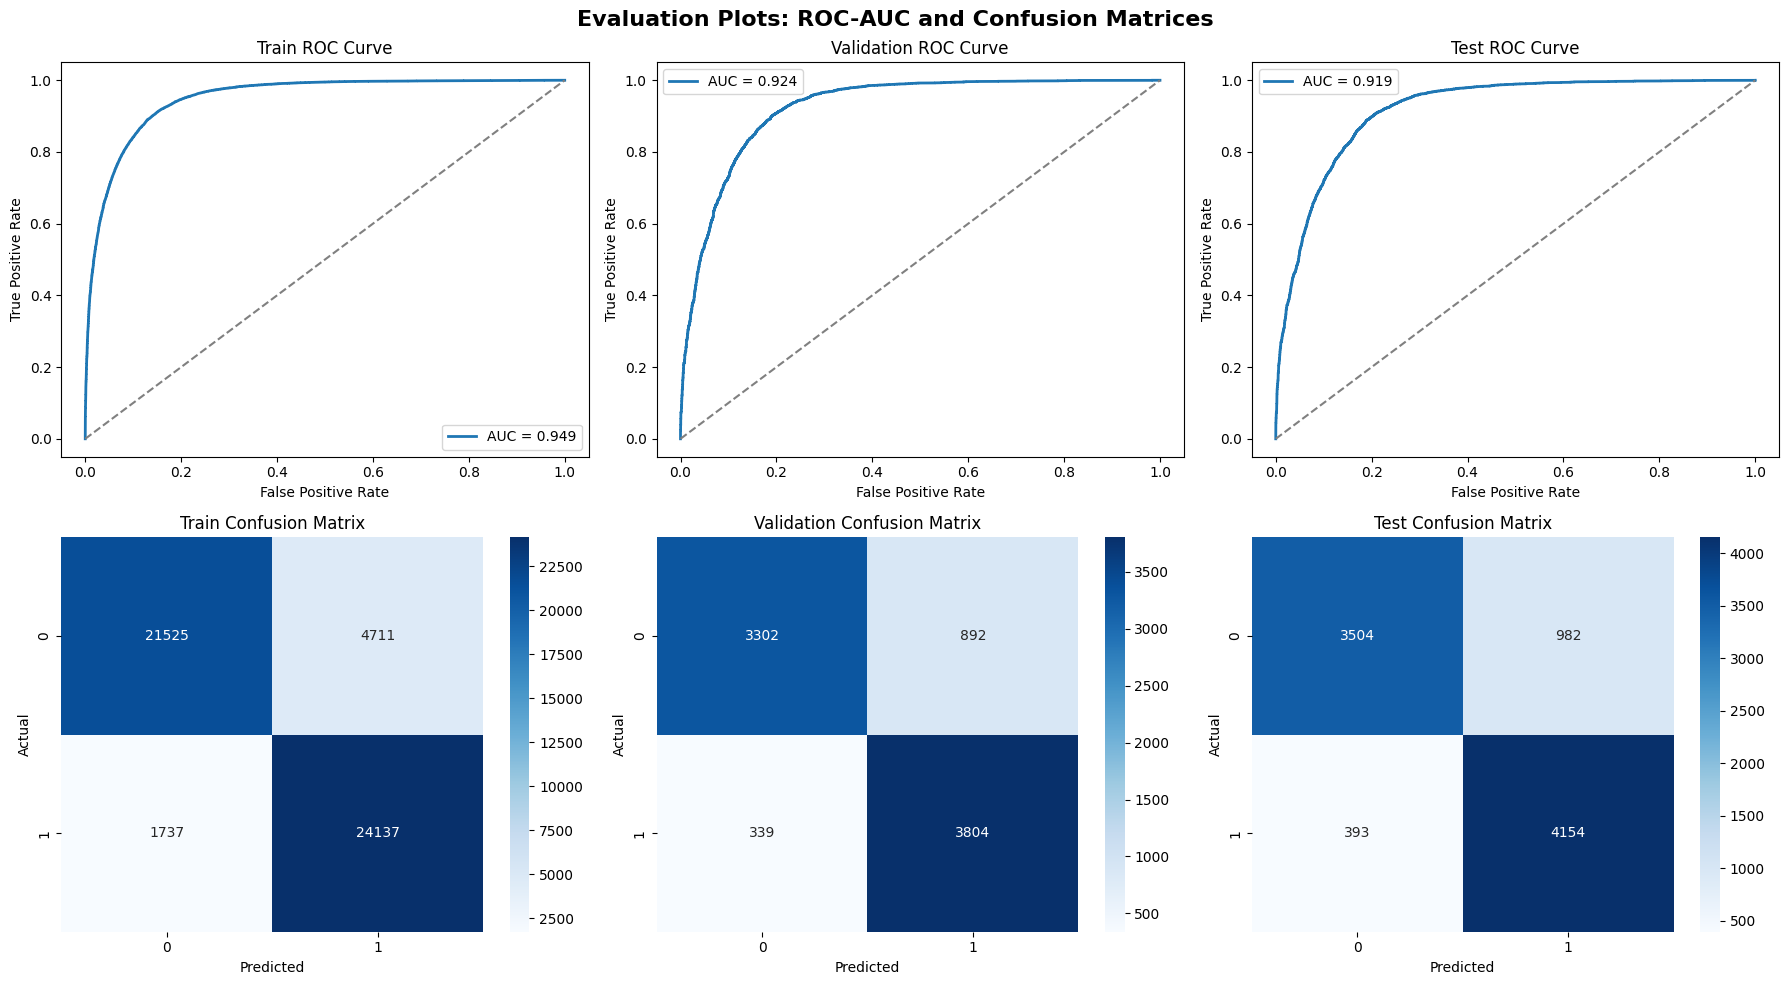

In [19]:
model_nb , results_nb, _, _, _ = evaluate_with_threshold(
    model=train_model(MultinomialNB(), X_train, y_train),
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    save_csv=True,
    filename="results/nb_results.csv"
)

print("\n Naive Bayes Results:")
display(results_nb)

plot_eval_charts(
    model=model_nb,
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5
)


In [20]:
def save_models(model_logistic, model_nb, vectorizer, folder="models"):

    # Create folder if not exists
    if not os.path.exists(folder):
        os.makedirs(folder)
        print("Folder created:", folder)

    # Save each file
    joblib.dump(model_logistic, f"{folder}/model_logistic.pkl")
    joblib.dump(model_nb, f"{folder}/model_nb.pkl")
    joblib.dump(vectorizer, f"{folder}/vectorizer.pkl")

    print("Models and vectorizer saved successfully!")


save_models(model_logistic, model_nb, vectorizer)


Models and vectorizer saved successfully!


In [21]:
def predict_sentiment(model, text, threshold=0.5):
    # preprocess input text
    cleaned = preprocess(text)

    # vectorize
    vec = vectorizer.transform([cleaned])

    # get probability of class 1 (positive)
    prob = model.predict_proba(vec)[0][1]   # index 1 → positive class

    # apply threshold
    label = 1 if prob > threshold else 0

    # readable output
    sentiment = " منفی" if label == 1 else " مثبت"

    print(f"🔍 جمله ورودی: {text}")
    print(f"📌 احتمال منفی بودن: {prob*100:.1f}")
    print(f"🏷️ نتیجه مدل: {sentiment}")

    return sentiment, prob

In [22]:
texts = ["افتضاح بود، خیلی دیر رسید و کیفیتش هم اصلا خوب نبود." , "غذا عالی بود، خیلی خوشمزه و سریع رسید، واقعا راضی‌ام.", "طعمش خوب بود ولی زمان تحویل خیلی طول کشید.", "خیلی خوب بود 😍🔥 دوباره سفارش می‌دم.", "اصلاً ارزش پول نداشت، فاجعه، دیگه هیچوقت سفارش نمی‌دم.",     "غذا خوب بود ولی خیلی دیر آوردن و سرد شده بود."]
for text in texts:
    predict_sentiment(model_nb , text)
    print('\n')

🔍 جمله ورودی: افتضاح بود، خیلی دیر رسید و کیفیتش هم اصلا خوب نبود.
📌 احتمال منفی بودن: 91.5
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا عالی بود، خیلی خوشمزه و سریع رسید، واقعا راضی‌ام.
📌 احتمال منفی بودن: 0.1
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: طعمش خوب بود ولی زمان تحویل خیلی طول کشید.
📌 احتمال منفی بودن: 30.9
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: خیلی خوب بود 😍🔥 دوباره سفارش می‌دم.
📌 احتمال منفی بودن: 21.8
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: اصلاً ارزش پول نداشت، فاجعه، دیگه هیچوقت سفارش نمی‌دم.
📌 احتمال منفی بودن: 98.0
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا خوب بود ولی خیلی دیر آوردن و سرد شده بود.
📌 احتمال منفی بودن: 37.7
🏷️ نتیجه مدل:  مثبت




In [23]:
for text in texts:
    predict_sentiment(model_logistic , text)
    print('\n')

🔍 جمله ورودی: افتضاح بود، خیلی دیر رسید و کیفیتش هم اصلا خوب نبود.
📌 احتمال منفی بودن: 95.5
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا عالی بود، خیلی خوشمزه و سریع رسید، واقعا راضی‌ام.
📌 احتمال منفی بودن: 0.1
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: طعمش خوب بود ولی زمان تحویل خیلی طول کشید.
📌 احتمال منفی بودن: 15.1
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: خیلی خوب بود 😍🔥 دوباره سفارش می‌دم.
📌 احتمال منفی بودن: 2.6
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: اصلاً ارزش پول نداشت، فاجعه، دیگه هیچوقت سفارش نمی‌دم.
📌 احتمال منفی بودن: 97.5
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا خوب بود ولی خیلی دیر آوردن و سرد شده بود.
📌 احتمال منفی بودن: 25.8
🏷️ نتیجه مدل:  مثبت




In [3]:
normalizer = Normalizer()

def preprocess(text):

    # normalize Persian
    text = normalizer.normalize(text)

    # replace patterns
    text = re.sub(r"http\S+|www\S+", "<URL>", text)
    text = re.sub(r"@\S+", "<USER>", text)
    text = re.sub(r"#(\S+)", r"\1", text)

    # keep valid persian chars and useful punctuation and emojis
    text = re.sub(r"[^۰-۹0-9a-zA-Zء-یئإأؤآ؟!.,🙂😂😍😡🤬⭐❤️💔 ]", " ", text)

    # replace numbers
    text = re.sub(r"[0-9۰-۹]+", "<NUM>", text)

    # cleanup spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [4]:
train_df["clean_text"] = train_df["comment"].apply(preprocess)
valid_df["clean_text"] = valid_df["comment"].apply(preprocess)
test_df["clean_text"] = test_df["comment"].apply(preprocess)

In [7]:
MAX_WORDS = 15000     # vocabulary size
MAX_LEN = 50         # max sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df["clean_text"])

# convert sentences → integer sequences
X_train = tokenizer.texts_to_sequences(train_df["clean_text"])
X_valid = tokenizer.texts_to_sequences(valid_df["clean_text"])
X_test  = tokenizer.texts_to_sequences(test_df["clean_text"])

# pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding="post")
X_valid = pad_sequences(X_valid, maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(X_test, maxlen=MAX_LEN, padding="post")

y_train = train_df["label_id"].values
y_valid = valid_df["label_id"].values
y_test  = test_df["label_id"].values


In [8]:
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

model = Sequential()

# Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=MAX_LEN))

model.add(LSTM(units=64, return_sequences=True, recurrent_dropout=0.3))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))


model.add(Dense(1, activation="sigmoid"))


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

checkpoint = ModelCheckpoint("./models/model_dl_lstm.h5", save_best_only=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=6,
    callbacks=[earlystop, checkpoint]
)


Epoch 1/6
814/815 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6543 - loss: 0.6120

815/815 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.7374 - loss: 0.5553 - val_accuracy: 0.8048 - val_loss: 0.4849
Epoch 2/6
814/815 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7748 - loss: 0.5184

815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.7698 - loss: 0.5242 - val_accuracy: 0.8015 - val_loss: 0.4631
Epoch 3/6
814/815 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8010 - loss: 0.4629

815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.8139 - loss: 0.4430 - val_accuracy: 0.8315 - val_loss: 0.4032
Epoch 4/6
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8516 - loss: 0.3721

815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.8540 - loss: 0.3625 - val_accuracy: 0.8477 - val_loss: 0.3596
Epoch 5/6
814/815 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8765 - loss: 0.3158

815/815 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8762 - loss: 0.3155 - val_accuracy: 0.8534 - val_loss: 0.3494
Epoch 6/6
815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.8891 - loss: 0.2833 - val_accuracy: 0.8499 - val_loss: 0.3543


In [14]:
def evaluate_model(model, history, X_test, y_test):
    """
    Evaluates a trained Keras model:
    - Computes metrics (ACC, Precision, Recall, F1, AUC)
    - Prints classification report
    - Plots Confusion Matrix
    - Plots ROC Curve
    - Plots Train/Validation Loss & Accuracy
    """

    # 1. Predict
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int)


    # 2. Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("\nModel Performance Test:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"AUC       : {auc:.4f}")

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_pred, digits=3))


    # 3. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"],
                yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


    # 4. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # 5. Train/Validation Loss & Accuracy
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, "b-", label="Train Loss")
    plt.plot(epochs, val_loss, "r--", label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
    plt.plot(epochs, val_acc, "r--", label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Model Performance Test:
Accuracy  : 0.8479
Precision : 0.8248
Recall    : 0.8861
F1-score  : 0.8543
AUC       : 0.9197

Classification Report (Test):
              precision    recall  f1-score   support

         0.0      0.875     0.809     0.841      4486
         1.0      0.825     0.886     0.854      4547

    accuracy                          0.848      9033
   macro avg      0.850     0.848     0.848      9033
weighted avg      0.850     0.848     0.848      9033



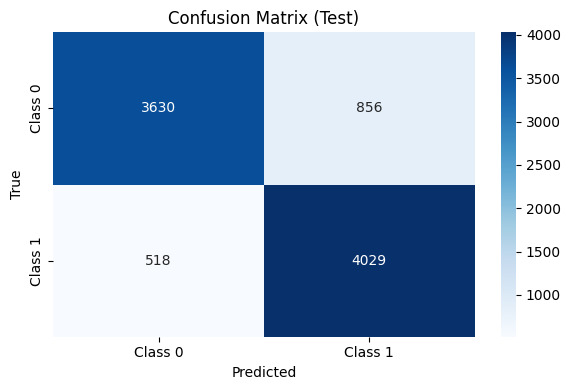

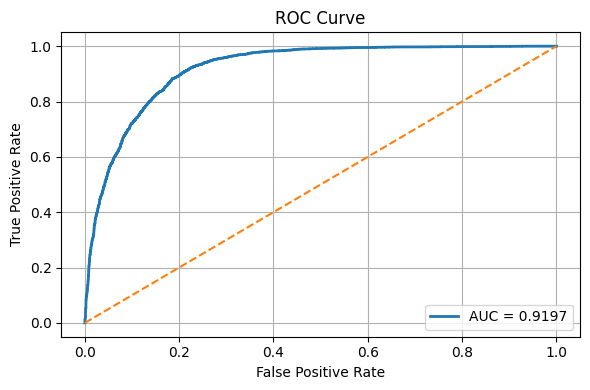

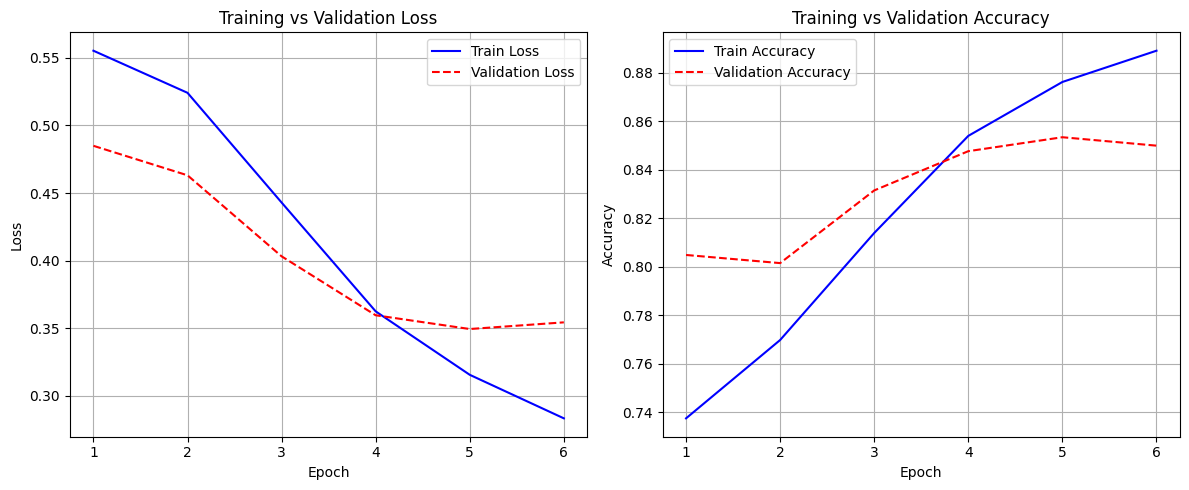

In [15]:
best_model = load_model("./models/model_dl_lstm.h5")
evaluate_model(model, history, X_test, y_test)